In [139]:
import sys 
!{sys.executable} -m pip list
!python --version


Package                      Version
---------------------------- -----------
absl-py                      2.3.1
asttokens                    3.0.0
astunparse                   1.6.3
cachetools                   5.5.2
certifi                      2025.7.9
charset-normalizer           3.4.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.3.2
cycler                       0.12.1
debugpy                      1.8.14
decorator                    5.2.1
exceptiongroup               1.3.0
executing                    2.2.0
flatbuffers                  25.2.10
fonttools                    4.58.5
gast                         0.4.0
google-auth                  2.40.3
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.73.1
h5py                         3.14.0
idna                         3.10
ipykernel                    6.29.5
ipython                      8.37.0
jedi                         0.19.2

## All Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, SpatialDropout2D, GlobalAveragePooling2D,
    Activation
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight


## TO SPLIT DATASET

In [ ]:
import os
import shutil
import random

# SETTINGS
source_dir = r'C:\Users\praha\Downloads\AMLAI_PROJECT\AMLAI_PROJECT\Main'  # Contains 'garlic' and 'bread_pastry'
dest_dir = r'C:\Users\praha\Downloads\AMLAI_PROJECT\AMLAI_PROJECT\Data\Data'  # Will contain 'train' and 'val'
split_ratio = 0.8  


random.seed(42)

# Class folders
classes = ['garlic', 'bread_pastry']

for cls in classes:
    class_path = os.path.join(source_dir, cls)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    # Split images
    split_index = int(len(images) * split_ratio)
    train_imgs = images[:split_index]
    val_imgs = images[split_index:]

    # Create new folders inside train and val
    train_dest = os.path.join(dest_dir, 'train', cls)
    val_dest = os.path.join(dest_dir, 'val', cls)
    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(val_dest, exist_ok=True)

    # Copy train images
    for img_name in train_imgs:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(train_dest, img_name)
        shutil.copy2(src, dst)

    # Copy val images
    for img_name in val_imgs:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(val_dest, img_name)
        shutil.copy2(src, dst)

    print(f"{cls}: {len(train_imgs)} images copied to train/, {len(val_imgs)} to val/")

print("\nDone splitting and copying images into train/val structure.")


garlic: 1331 images copied to train/, 333 to val/
bread_pastry: 1336 images copied to train/, 334 to val/

✅ Done splitting and copying images into train/val structure.


## Train data

In [4]:


train = r'C:\Users\praha\Downloads\AMLAI_PROJECT\AMLAI_PROJECT\Data\Data\train'
val = r'C:\Users\praha\Downloads\AMLAI_PROJECT\AMLAI_PROJECT\Data\Data\val'
test = r'C:\Users\praha\Downloads\AMLAI_PROJECT\AMLAI_PROJECT\Data\Data\test'


In [ ]:


# === Parameters ===
img_size = (180, 180)
input_shape = (180, 180, 3)
num_classes = 3
batch_size = 32
initial_learning_rate = 1e-4


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2630 images belonging to 3 classes.
Found 1030 images belonging to 3 classes.


In [ ]:


# Compute class weights 
classes = train_generator.classes  

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

# Convert to dictionary form for Keras
class_weights = dict(enumerate(class_weights))

# Print dataset summary
print(" Data Distribution Summary:")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Class weights: {class_weights}")

# Detailed class breakdown
print("\n Class Counts:")
print("Training class distribution:", np.bincount(train_generator.classes))
print("Validation class distribution:", np.bincount(val_generator.classes))
print("Class labels (0 → ?, 1 → ?):", train_generator.class_indices)


📊 Data Distribution Summary:
Training samples: 2630
Validation samples: 1030
Class weights: {0: np.float64(0.9850187265917603), 1: np.float64(1.0277452129738178), 2: np.float64(0.9883502442690718)}

🔍 Class Counts:
Training class distribution: [890 853 887]
Validation class distribution: [334 333 363]
Class labels (0 → ?, 1 → ?): {'bread_pastry': 0, 'garlic': 1, 'unknown': 2}


## MODEL BUILDING

In [15]:


model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(2e-4), kernel_constraint=MaxNorm(3),
           input_shape=(180, 180, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.2),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(2e-4), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(2e-4), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.3),

    # Block 3.5 (Lightweight)
    Conv2D(128, (1, 1), activation='relu', padding='same',
           kernel_regularizer=l2(2e-4), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    SpatialDropout2D(0.3),

    # Global pooling + Dense head
    GlobalAveragePooling2D(),

    Dense(96, activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=l2(1e-5),
          kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    Dropout(0.5), 

    Dense(48, activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=l2(1e-5),
          kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(3, activation='softmax')
])


NameError: name 'Sequential' is not defined

In [ ]:


# === Input Shape & Params ===
input_shape = (180, 180, 3)
num_classes = 3
batch_size = 32

# === Optimizer ===
optimizer = Adam(learning_rate=1e-4)  # ✅ Fixed LR (suitable for ReduceLROnPlateau)

# === Loss Function ===
loss = CategoricalCrossentropy(from_logits=False, label_smoothing=0.2)

# === EMA Callback ===
class EMACallback(tf.keras.callbacks.Callback):
    def __init__(self, decay=0.999):
        super().__init__()
        self.decay = decay
        self.shadow_weights = []

    def on_train_begin(self, logs=None):
        self.shadow_weights = [tf.identity(w) for w in self.model.get_weights()]

    def on_batch_end(self, batch, logs=None):
        current_weights = self.model.get_weights()
        for i in range(len(current_weights)):
            self.shadow_weights[i] = (
                self.decay * self.shadow_weights[i] + (1.0 - self.decay) * current_weights[i]
            )

    def on_train_end(self, logs=None):
        self.model.set_weights(self.shadow_weights)

# === Callbacks ===
callbacks = [
    EarlyStopping(
        monitor='val_categorical_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_smooth_modelv15.keras',
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    ),
    EMACallback(decay=0.999)
]

# === Compile Model ===
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        'categorical_accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# === Summary ===
model.summary()


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_98 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_158         │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_24            │ (None, 90, 90, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_159         │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_25            │ (None, 45, 45, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_160         │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_26            │ (None, 22, 22, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 22, 22, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_161         │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_27            │ (None, 22, 22, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_30     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_162         │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 48)             │         4,65

 Total params: 128,931 (503.64 KB)

 Trainable params: 127,939 (499.76 KB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


c:\Users\praha\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4292 - loss: 1.6312 - precision: 0.4366 - recall: 0.3786
Epoch 1: val_categorical_accuracy improved from -inf to 0.32330, saving model to best_smooth_modelv15.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - categorical_accuracy: 0.4294 - loss: 1.6300 - precision: 0.4370 - recall: 0.3789 - val_categorical_accuracy: 0.3233 - val_loss: 1.3513 - val_precision: 0.3233 - val_recall: 0.3233 - learning_rate: 1.0000e-04
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5335 - loss: 1.3513 - precision: 0.5627 - recall: 0.4918
Epoch 2: val_categorical_accuracy did not improve from 0.32330
83/83 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - categorical_accuracy: 0.5337 - loss: 1.3507 - precision: 0.5629 - recall: 0.4920 - val_categorical_accuracy: 0.3233 - val_loss: 1.5664 - val_precision: 0.3242 - val_recall: 0.3233 - learning_rate: 1.0000e-04
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_ac

## model SAVE

In [267]:
import os

def get_next_model_filename(base_name='pastry_model_basev', 
                            folder=r'E:\PRAHA FOLDER\AMLAI_PROJECT', 
                            ext='.hdf5'):
    i = 1
    while True:
        filename = f"{base_name}{i}{ext}"
        full_path = os.path.join(folder, filename)
        if not os.path.exists(full_path):
            return full_path
        i += 1

filename = get_next_model_filename(folder=r'.')  # Use raw string if needed here, or just '.'
model.save(filename)
print(f"Model saved as {filename}")


Model saved as .\pastry_model_basev20.hdf5


## MDOEL TESTING WITH TEST DATA

In [14]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


NameError: name 'history' is not defined

In [ ]:


model = load_model("best_smooth_modelv15.keras", compile=False)


model.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', Precision(), Recall()]
)

# Evaluate
val_loss, val_acc, val_precision, val_recall = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Precision: {val_precision:.4f}")
print(f"✅ Recall: {val_recall:.4f}")
print(f"✅ Loss: {val_loss:.4f}")

# Predict on validation set
y_true = val_generator.classes  
y_pred_probs = model.predict(val_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)     

# Confusion Matrix
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


Found 411 images belonging to 3 classes.


c:\Users\praha\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9275 - loss: 0.4871 - precision_5: 0.9545 - recall_5: 0.8824

📈 Test Accuracy: 0.8735
✅ Test Precision: 0.8989
✅ Test Recall: 0.8224
📉 Test Loss: 0.6067
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step


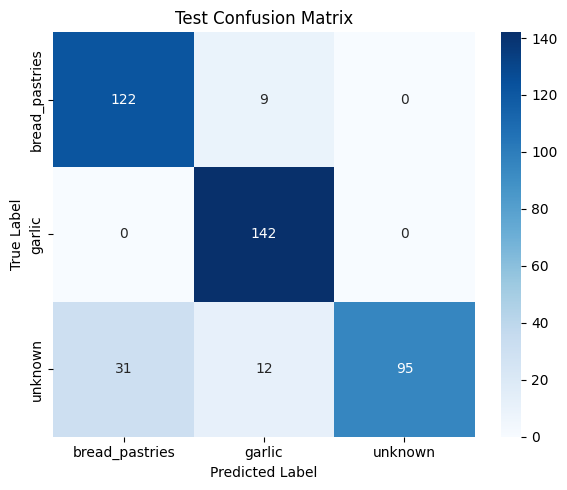


🧾 Classification Report:
                precision    recall  f1-score   support

bread_pastries       0.80      0.93      0.86       131
        garlic       0.87      1.00      0.93       142
       unknown       1.00      0.69      0.82       138

      accuracy                           0.87       411
     macro avg       0.89      0.87      0.87       411
  weighted avg       0.89      0.87      0.87       411



In [ ]:


IMAGE_SIZE = (180, 180)
BATCH_SIZE = 32


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test,     
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',3
    shuffle=False  
)


model = load_model('best_smooth_modelv15.keras', compile=False)

model.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', Precision(), Recall()]
)

# Evaluate the model
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator)
print(f"\n📈 Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Precision: {test_prec:.4f}")
print(f"✅ Test Recall: {test_rec:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

#  Predict
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))
